In [ ]:
pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import seaborn as sns

In [ ]:
data = pd.read_csv('../data/consolidated_signals.csv')
data['date'] = pd.to_datetime(data['date'])
start_date = '2020-04-20'
end_date = '2023-03-16'
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
data = pd.get_dummies(data, prefix=['weather'], columns=['weather'])
data
#rename for prophet requirement
data = data.rename(columns={"date": "ds", "ridership": "y"})

In [ ]:
#check null values
print(data.isna().sum())

ds                                       0
y                                        0
day temp                                 2
night temp                               2
barclays-center_event_occurred           0
beacon-theatre_event_occurred            0
blue-note-jazz-club_event_occurred       0
brooklyn-bowl_event_occurred             0
carnegie-hall_event_occurred             0
city-winery-the-loft_event_occurred      0
total_comedy                             0
total_events                             0
total_film-screenings                    0
forest-hills-stadium_event_occurred      0
irving-plaza_event_occurred              0
kings-theatre_event_occurred             0
lincoln-center_event_occurred            0
madison-square-garden_event_occurred     0
mercury-lounge_event_occurred            0
metlife-stadium_event_occurred           0
total_music                              0
palladium-times-square_event_occurred    0
radio-city-music-hall_event_occurred     0
sony-hall_e

In [ ]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1059 entries, 110 to 1170
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   ds                                     1059 non-null   datetime64[ns]
 1   y                                      1059 non-null   float64       
 2   day temp                               1059 non-null   float64       
 3   night temp                             1059 non-null   float64       
 4   barclays-center_event_occurred         1059 non-null   int64         
 5   beacon-theatre_event_occurred          1059 non-null   int64         
 6   blue-note-jazz-club_event_occurred     1059 non-null   int64         
 7   brooklyn-bowl_event_occurred           1059 non-null   int64         
 8   carnegie-hall_event_occurred           1059 non-null   int64         
 9   city-winery-the-loft_event_occurred    1059 non-null   int64 

In [ ]:
#slice the training period: 02.01.2022 – 03.02.2023 
fold7 = data[(data['ds'] >= "2022-02-01") & (data['ds'] <= "2023-03-02")]
#slice the testing period: 3.03.2023 – 03.16.2023
testing = data[(data['ds'] >= "2023-03-03") & (data['ds'] <= "2023-03-16")]

#grid search for smallest mape value

In [ ]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 10],
    'seasonality_mode':['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the RMSEs for each params here
forecast_list = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(fold7)  # Fit model with given params
    forecast = m.predict(testing)
    score = np.mean(np.abs((testing['y'].values - forecast['yhat'].values)/testing['y'].values))*100
    forecast['score'] = score
    mapes.append(score)
    forecast_list.append(forecast)

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp31j20yyw/72g3h0y4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp31j20yyw/a221_5hc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87259', 'data', 'file=/tmp/tmp31j20yyw/72g3h0y4.json', 'init=/tmp/tmp31j20yyw/a221_5hc.json', 'output', 'file=/tmp/tmp31j20yyw/prophet_model2ttyew_b/prophet_model-20230510180838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:08:38 - cmdstanpy - ERROR - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.001                     0.01                  0.01   
1                     0.001                     0.01                  0.01   
2                     0.001                     0.01                 10.00   
3                     0.001                     0.01                 10.00   
4                     0.001                     0.10                  0.01   
..                      ...                      ...                   ...   
59                    0.500                     1.00                 10.00   
60                    0.500                    10.00                  0.01   
61                    0.500                    10.00                  0.01   
62                    0.500                    10.00                 10.00   
63                    0.500                    10.00                 10.00   

   seasonality_mode       mape  
0          additive  12.305726

In [ ]:
#get all "mape" values from grid search
tuning_results.sort_values('mape', ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,mape
31,0.010,10.00,10.00,multiplicative,4.240327
29,0.010,10.00,0.01,multiplicative,4.240327
27,0.010,1.00,10.00,multiplicative,4.249303
25,0.010,1.00,0.01,multiplicative,4.249303
9,0.001,1.00,0.01,multiplicative,4.374963
...,...,...,...,...,...
51,0.500,0.01,10.00,multiplicative,17.766339
3,0.001,0.01,10.00,multiplicative,17.961046
1,0.001,0.01,0.01,multiplicative,17.961046
35,0.100,0.01,10.00,multiplicative,18.060400


In [ ]:
min_score = min([df['score'].min() for df in forecast_list])
#get the most accurate prediction
acc_pre = pd.DataFrame([df for df in forecast_list if df['score'].min() == min_score][0])
acc_pre

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,score
0,2023-03-03,3.066889e+06,3.058699e+06,3.813703e+06,3.066889e+06,3.066889e+06,0.114732,0.114732,0.114732,0.114732,0.114732,0.114732,0.0,0.0,0.0,3.418760e+06,4.240327
1,2023-03-04,3.067962e+06,1.867908e+06,2.686864e+06,3.067962e+06,3.067962e+06,-0.256007,-0.256007,-0.256007,-0.256007,-0.256007,-0.256007,0.0,0.0,0.0,2.282541e+06,4.240327
2,2023-03-05,3.069034e+06,1.432395e+06,2.196724e+06,3.069034e+06,3.069034e+06,-0.415023,-0.415023,-0.415023,-0.415023,-0.415023,-0.415023,0.0,0.0,0.0,1.795314e+06,4.240327
3,2023-03-06,3.070107e+06,2.722336e+06,3.511107e+06,3.070107e+06,3.070107e+06,0.014608,0.014608,0.014608,0.014608,0.014608,0.014608,0.0,0.0,0.0,3.114955e+06,4.240327
4,2023-03-07,3.071180e+06,3.205078e+06,3.969136e+06,3.071180e+06,3.071180e+06,0.166563,0.166563,0.166563,0.166563,0.166563,0.166563,0.0,0.0,0.0,3.582723e+06,4.240327
5,2023-03-08,3.072252e+06,3.245101e+06,4.080419e+06,3.072252e+06,3.072253e+06,0.193597,0.193597,0.193597,0.193597,0.193597,0.193597,0.0,0.0,0.0,3.667031e+06,4.240327
6,2023-03-09,3.073325e+06,3.230499e+06,4.036282e+06,3.073324e+06,3.073326e+06,0.181531,0.181531,0.181531,0.181531,0.181531,0.181531,0.0,0.0,0.0,3.631227e+06,4.240327
7,2023-03-10,3.074398e+06,3.064616e+06,3.788783e+06,3.074396e+06,3.074399e+06,0.114732,0.114732,0.114732,0.114732,0.114732,0.114732,0.0,0.0,0.0,3.427131e+06,4.240327
8,2023-03-11,3.075471e+06,1.905118e+06,2.700856e+06,3.075469e+06,3.075473e+06,-0.256007,-0.256007,-0.256007,-0.256007,-0.256007,-0.256007,0.0,0.0,0.0,2.288128e+06,4.240327
9,2023-03-12,3.076543e+06,1.398927e+06,2.192270e+06,3.076541e+06,3.076546e+06,-0.415023,-0.415023,-0.415023,-0.415023,-0.415023,-0.415023,0.0,0.0,0.0,1.799707e+06,4.240327


Plot the prediction with lowest MAPE value: 4.24%

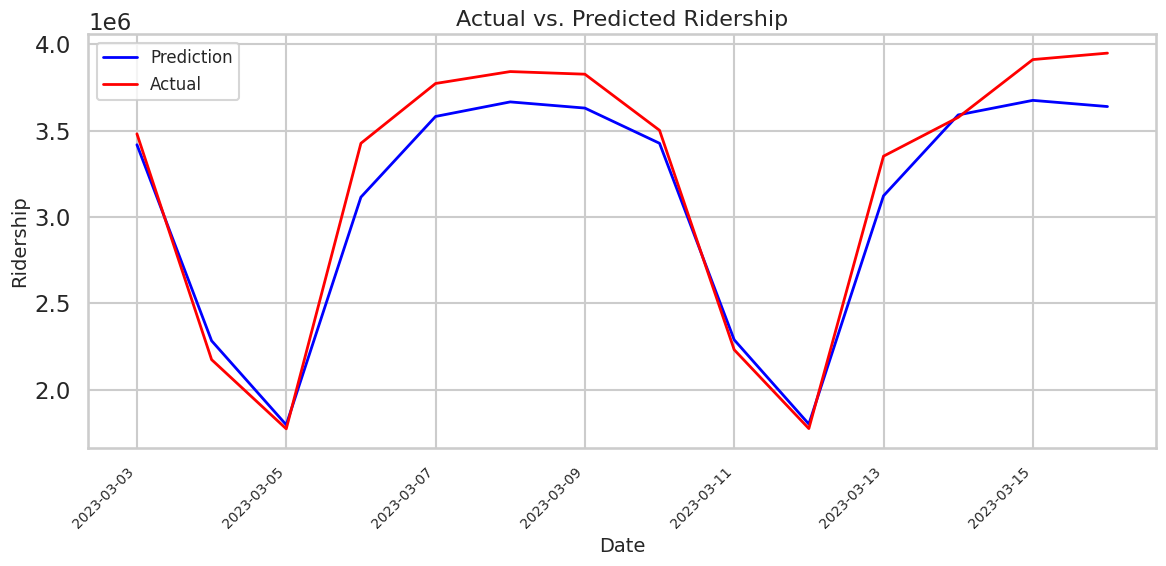

In [ ]:
plt.figure(figsize=(12, 6))
# Plot only the forecast
plt.plot(dates, acc_pre['yhat'], label='Prediction', color='blue', linewidth=2)
plt.plot(dates, testing['y'], label='Actual', color='red', linewidth=2)

# Set the title and axis labels
plt.title('Actual vs. Predicted Ridership', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Ridership', fontsize=14)

# Add a grid and legend
plt.grid(True)
plt.legend(loc='upper left', fontsize=12)

# Customize the x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


Get the distribution of MAPE values for each grid search combination

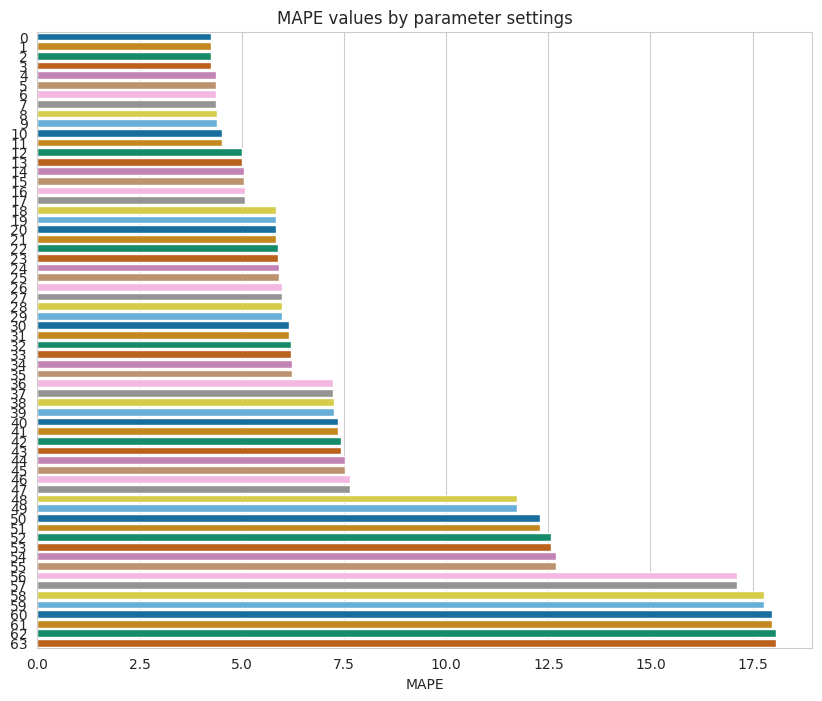

In [ ]:
# Sort the dataframe by 'mape'
tuning_results_sorted = tuning_results.sort_values(by='mape',ascending =True).reset_index()

# Create a horizontal bar chart
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='mape', y=tuning_results_sorted.index, data=tuning_results_sorted, ax=ax, palette='colorblind',orient='h')

# Add labels and a title
ax.set_xlabel('MAPE')
ax.set_ylabel('')
ax.set_title('MAPE values by parameter settings')

# Show the plot
plt.show()